In [1]:
## import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [14]:
!hdfs dfs -put /home/master/Downloads/LC

In [15]:
!hdfs dfs -ls LC

Found 4 items
-rw-r--r--   1 master supergroup   48972958 2019-02-14 20:41 LC/LoanStats_2017Q1.csv
-rw-r--r--   1 master supergroup   53375969 2019-02-14 20:41 LC/LoanStats_2017Q2.csv
-rw-r--r--   1 master supergroup   62360603 2019-02-14 20:41 LC/LoanStats_2017Q3.csv
-rw-r--r--   1 master supergroup   59925365 2019-02-14 20:41 LC/LoanStats_2017Q4.csv


In [2]:
loans = spark.read.format("com.databricks.spark.csv")\
.option("header", "true")\
.option("inferSchema", "true").\
load(["hdfs://localhost:8020/user/master/LC/LoanStats_2017Q1.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q2.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q3.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q4.csv"])

In [3]:
# type
type(loans)

pyspark.sql.dataframe.DataFrame

In [4]:
loans.count()

443579

In [5]:
# in-memory-usage
loans.cache()

DataFrame[id: string, member_id: string, loan_amnt: string, funded_amnt: string, funded_amnt_inv: string, term: string, int_rate: string, installment: string, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, pymnt_plan: string, url: string, desc: string, purpose: string, title: string, zip_code: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_p

In [3]:
loans.createOrReplaceTempView("loans")

In [7]:
spark.sql("SELECT * FROM loans LIMIT 1").show(n=1)

+----+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+----+----+-------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+

In [8]:
spark.sql("SELECT * FROM loans LIMIT 5").toPandas().head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term;
0,None,None,2000,2000,2000,36,8.24,62.9,B,B1,...,None,None,Cash,N,None,None,None,None,None,;
1,None,None,30000,30000,30000,36,5.32,903.45,A,A1,...,None,None,Cash,N,None,None,None,None,None,;
2,None,None,14400,14400,14400,36,5.32,433.66,A,A1,...,None,None,Cash,N,None,None,None,None,None,;
3,None,None,5000,5000,5000,36,30.74,214.29,F,F5,...,None,None,Cash,N,None,None,None,None,None,;
4,None,None,24000,24000,24000,36,25.49,960.47,E,E4,...,None,None,Cash,N,None,None,None,None,None,;


In [4]:
loans_a = loans['int_rate', 'loan_amnt','term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc','verification_status','purpose','addr_state', 'open_acc']

In [13]:
#missing value analysis
loans_a.toPandas().isnull().sum()

int_rate                   0
loan_amnt                  0
term                       0
grade                      0
sub_grade                  0
emp_length             31877
home_ownership             6
annual_inc                 6
verification_status        6
purpose                    6
addr_state                 6
open_acc                   6
dtype: int64

In [24]:
#fill missing values with 0 or N/A
loans_a = loans_a.withColumn("emp_length", when(loans_a["emp_length"] == 'n/a', 0).otherwise(loans_a["emp_length"]))
loans_a = loans_a.withColumn("open_acc", when(loans_a["open_acc"] == '', 0).otherwise(loans_a["loan_amnt"]))
loans_a = loans_a.withColumn("annual_inc", when(loans_a["annual_inc"] == '', 0).otherwise(loans_a["annual_inc"]))
loans_a = loans_a.withColumn("home_ownership", when(loans_a["home_ownership"] == '', 'None').otherwise(loans_a["home_ownership"]))
loans_a = loans_a.withColumn("verification_status", when(loans_a["verification_status"] == '', 'None').otherwise(loans_a["verification_status"]))
loans_a = loans_a.withColumn("purpose", when(loans_a["purpose"] == '', 'None').otherwise(loans_a["purpose"]))
loans_a = loans_a.withColumn("addr_state", when(loans_a["addr_state"] == '', 'None').otherwise(loans_a["addr_state"]))

In [25]:
#missing value analysis after filling values
loans_a.toPandas().isnull().sum()

int_rate               0
loan_amnt              0
term                   0
grade                  0
sub_grade              0
emp_length             6
home_ownership         6
annual_inc             6
verification_status    6
purpose                6
addr_state             6
open_acc               0
dtype: int64

In [30]:
loans_a = loans_a.filter(loans_a.purpose != '')

In [31]:
loans_a.toPandas().isnull().sum()

int_rate               0
loan_amnt              0
term                   0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
addr_state             0
open_acc               0
dtype: int64

In [5]:
loans_a = loans_a.withColumn("loan_amnt", loans_a["loan_amnt"].cast(IntegerType()))
loans_a = loans_a.withColumn("term", loans_a["term"].cast(IntegerType()))
loans_a = loans_a.withColumn("emp_length", loans_a["emp_length"].cast(IntegerType()))
loans_a = loans_a.withColumn("annual_inc", loans_a["annual_inc"].cast(IntegerType()))
loans_a = loans_a.withColumn("open_acc", loans_a["open_acc"].cast(IntegerType()))
loans_a = loans_a.withColumn("int_rate", loans_a["int_rate"].cast(IntegerType()))

In [33]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)



In [34]:
loans_a.toPandas().head(5)

,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,8,2000,36,B,B1,1,MORTGAGE,85816,Source Verified,moving,MN,2000
1,5,30000,36,A,A1,1,OWN,150000,Verified,debt_consolidation,IL,30000
2,5,14400,36,A,A1,1,MORTGAGE,117000,Not Verified,credit_card,NC,14400
3,30,5000,36,F,F5,1,RENT,150000,Verified,debt_consolidation,NY,5000
4,25,24000,36,E,E4,1,RENT,110000,Verified,debt_consolidation,IL,24000


In [35]:
# extract data from HDFS using pyspark
loans_int_rate = loans_a[['int_rate']]
type(loans_int_rate)

pyspark.sql.dataframe.DataFrame

In [36]:
loans_int_rate_pd = loans_int_rate.toPandas()
loans_int_rate_pd.head(5)
#type(loans_int_rate_pd)

,int_rate
0,8
1,5
2,5
3,30
4,25


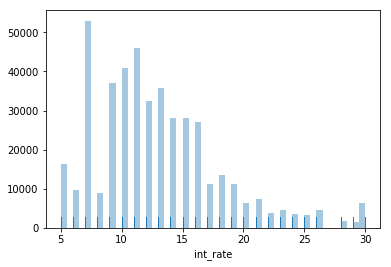

In [37]:
# use seaborn to plot the pandas object
# extract the column first

sns.distplot(loans_int_rate_pd['int_rate'], kde=False, rug=True) # bin = Number of bars
# Please try a densityplot

In [38]:
status_count = spark.sql("SELECT verification_status, count(*) as status_count \
                    FROM loans \
                    GROUP BY verification_status \
                    ORDER BY status_count DESC").toPandas()

In [39]:
status_count.head(5)

,verification_status,status_count
0,Source Verified,171642
1,Not Verified,158653
2,Verified,113278
3,None,6


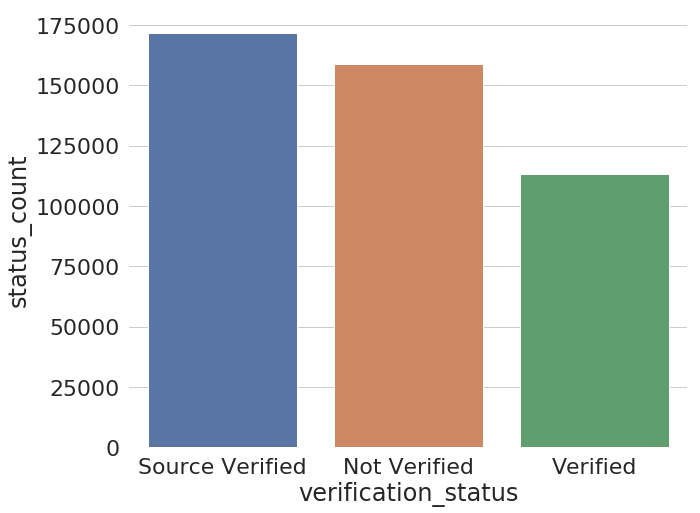

In [41]:
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(10,8))

plt.setp(ax, yticks=np.arange(0,200000, step=25000))
sns.set(font_scale=4.0)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

sns.barplot(x = 'verification_status', y = 'status_count', data=status_count)

In [45]:
state_count = spark.sql("SELECT addr_state, count(*) as loan_count \
                    FROM loans \
                    GROUP BY addr_state \
                    ORDER BY loan_count DESC").toPandas()

In [46]:
state_count.head(10)

,addr_state,loan_count
0,CA,59851
1,TX,37259
2,NY,37199
3,FL,31934
4,IL,18307
5,NJ,16174
6,PA,15045
7,OH,14464
8,GA,14253
9,NC,12096


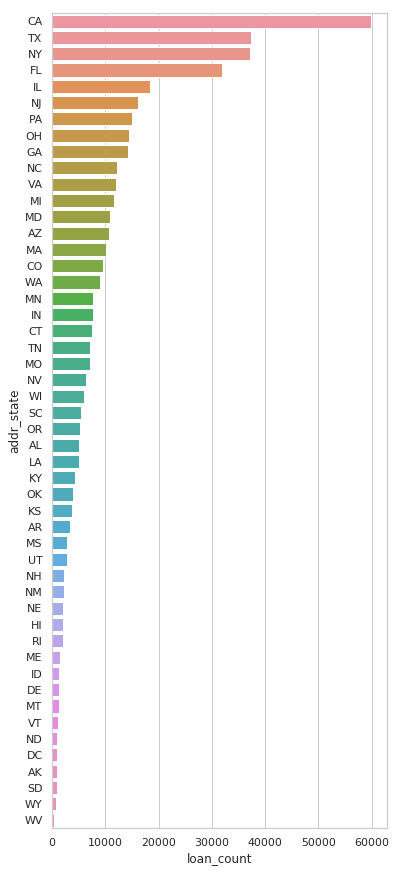

In [47]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

#states = sns.load_dataset("state_count").sort_values("state_count", ascending=False)


# Plot the states
sns.set_color_codes("muted")
sns.barplot(x="loan_count", y="addr_state", 
            data=state_count,
            label="Loans_Approved", 
            orient = "h")

In [48]:
purpose = spark.sql("SELECT purpose, count(*) as loan_purpose \
                    FROM loans \
                    GROUP BY purpose \
                    ORDER BY loan_purpose DESC").toPandas()

In [58]:
purpose.head(10)

,purpose,loan_purpose
0,debt_consolidation,245078
1,credit_card,91466
2,home_improvement,34692
3,other,33057
4,major_purchase,11140
5,medical,6885
6,car,5357
7,small_business,4938
8,vacation,4026
9,moving,3644


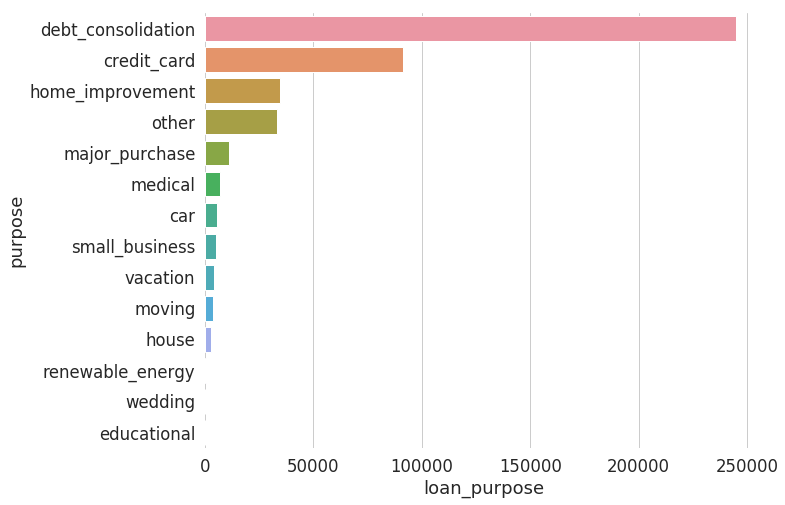

In [60]:
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(10,8))

plt.setp(ax, yticks=np.arange(0,250000, step=20000))
sns.set(font_scale=1.5)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

sns.barplot(x = 'loan_purpose', y = 'purpose', data=purpose, orient = "h")

In [62]:
howner = spark.sql("SELECT home_ownership, count(*) as loan_count \
                    FROM loans \
                    GROUP BY home_ownership \
                    ORDER BY loan_count DESC").toPandas()

In [63]:
howner.head(5)

,home_ownership,loan_count
0,MORTGAGE,217121
1,RENT,173640
2,OWN,52413
3,ANY,395
4,None,6


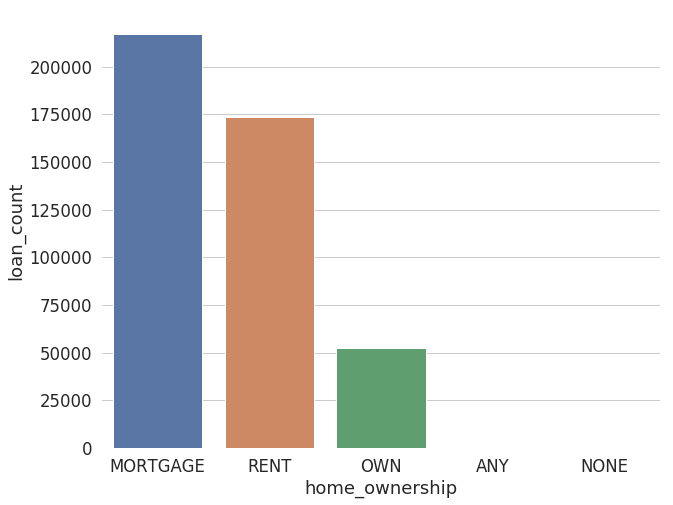

In [68]:
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(10,8))

plt.setp(ax, yticks=np.arange(0,225000, step=25000))
sns.set(font_scale=1.5)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

sns.barplot(x = 'home_ownership', y = 'loan_count', data=howner)

In [6]:
loans_num = spark.sql("SELECT int_rate, loan_amnt, term, emp_length, annual_inc, open_acc \
                    FROM loans").toPandas()

In [7]:
loans_num.head(5)

,int_rate,loan_amnt,term,emp_length,annual_inc,open_acc
0,20.00,2800,36,0,1.0,13
1,10.91,11000,36,0,1.0,14
2,24.85,19200,60,0,1.0,11
3,19.03,25000,60,0,1.0,13
4,7.35,20000,36,0,1.0,8


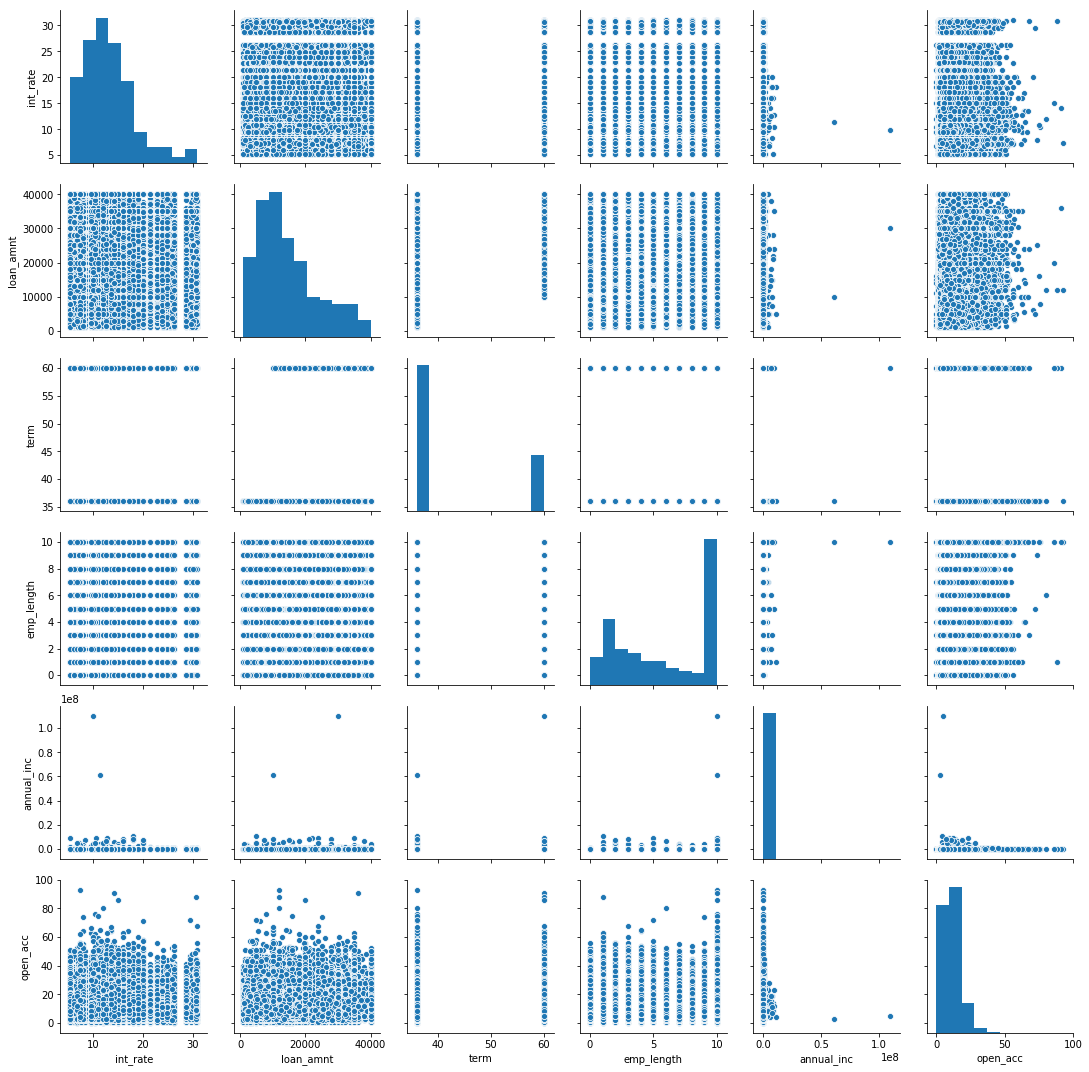

In [8]:
sns.pairplot(loans_num)

In [9]:
loans_num_corr = loans_num.corr()
loans_num_corr

,int_rate,loan_amnt,term,emp_length,annual_inc,open_acc
int_rate,1.000000,0.114794,0.344509,-0.025720,-0.031142,-0.007400
loan_amnt,0.114794,1.000000,0.398295,0.083589,0.117028,0.176732
term,0.344509,0.398295,1.000000,0.048573,0.025745,0.069868
emp_length,-0.025720,0.083589,0.048573,1.000000,0.046695,0.081431
annual_inc,-0.031142,0.117028,0.025745,0.046695,1.000000,0.056100
open_acc,-0.007400,0.176732,0.069868,0.081431,0.056100,1.000000


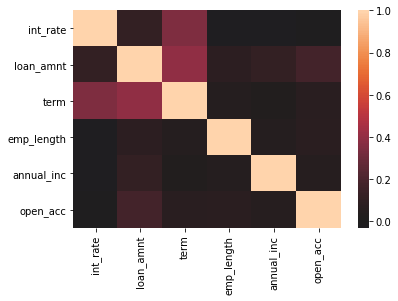

In [11]:
sns.heatmap(loans_num_corr, center=0)